# Project Overview: Heart Disease Prediction

Research Question: Based on a person’s health factors, lifestyle choices and demographics, what is the likely risk of heart disease? 
We'll be testing out Logistic Regression, Decision Trees, Random Forest and Gradient Boosting models in order to find the best prediction model.
Since it will be critical to be able to predict the risk of heart disease with the most accuracy, we'll focus on maximizing the Recall metric (to minimize the number of false negatives), followed by the F1 metric, to avoid too many false positives.


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import tensorflow as tf

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import plotly.express as px

# pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.combine import SMOTEENN

# modeling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from tabulate import tabulate
import time

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

print("All modules loaded")

All modules loaded


## 1. Exploratory Data Analysis (EDA)

In [2]:
# loading the data
url = '/Users/oaxana/Desktop/000_Berkeley/CAPSTONE/heart_2022_with_nans.csv.zip'
df = pd.read_csv(url, sep = ',', na_values = "unknown")

In [3]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [4]:
df.shape

(445132, 40)

In [5]:
df.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

In [7]:
# checking for duplicates
df.duplicated().sum()

157

In [8]:
# removing duplicates
df = df.drop_duplicates()

In [9]:
# describing numerical features
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434053.000000,435913.000000,439527.000000,416470.000000,403044.000000,396316.000000
mean,4.349372,4.384164,7.022909,1.702690,83.074632,28.529907
std,8.689968,8.388541,1.502618,0.107178,21.448241,6.554917
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


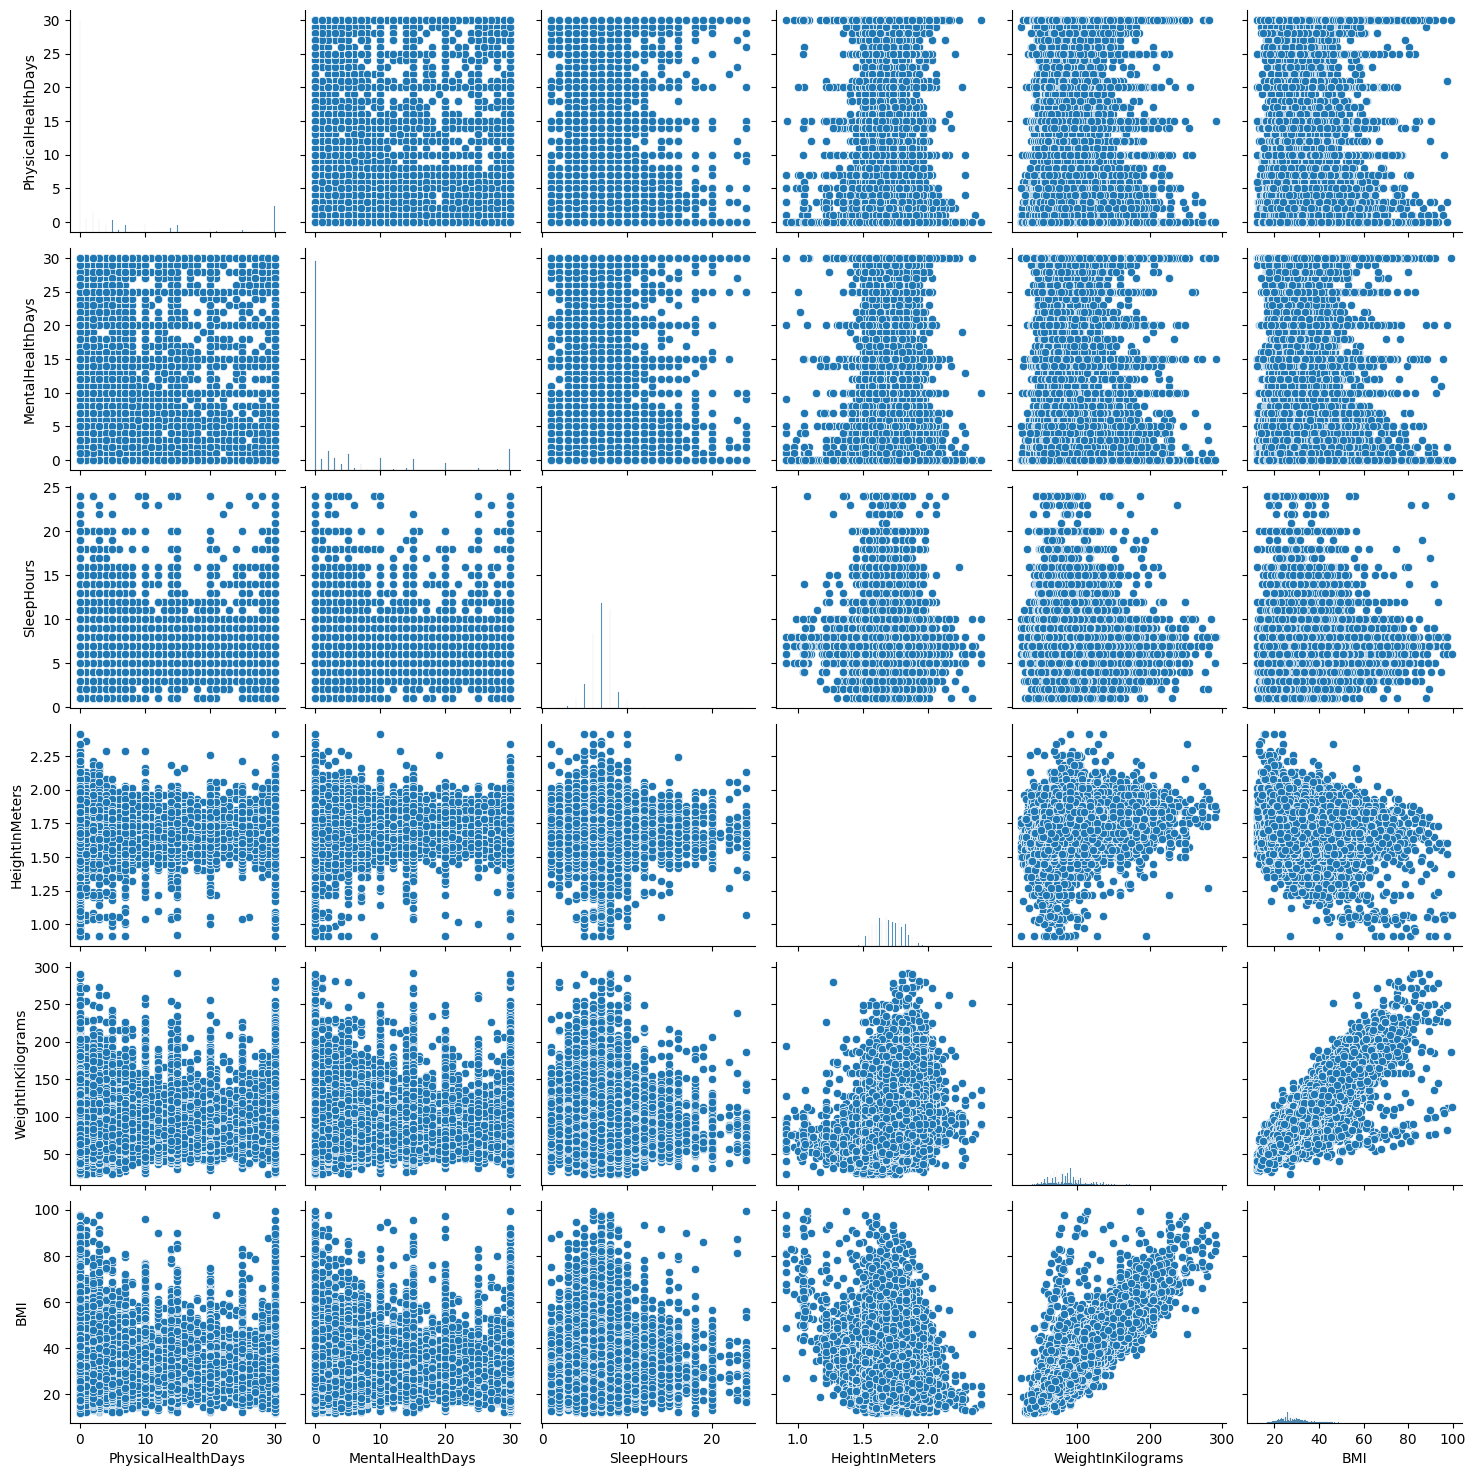

In [10]:
# pairplots to view all numerical features and their correlations and distributions
sns.pairplot(df.select_dtypes(include=['number']))
plt.show()

### Highlight from examining Pairplots:

- High correlation between WeightInKilograms and BMI features, which is expected due to the nature of the BMI metric's definition BMI = Weight(kg)/Height(m)^2
- No significan correlations between other features

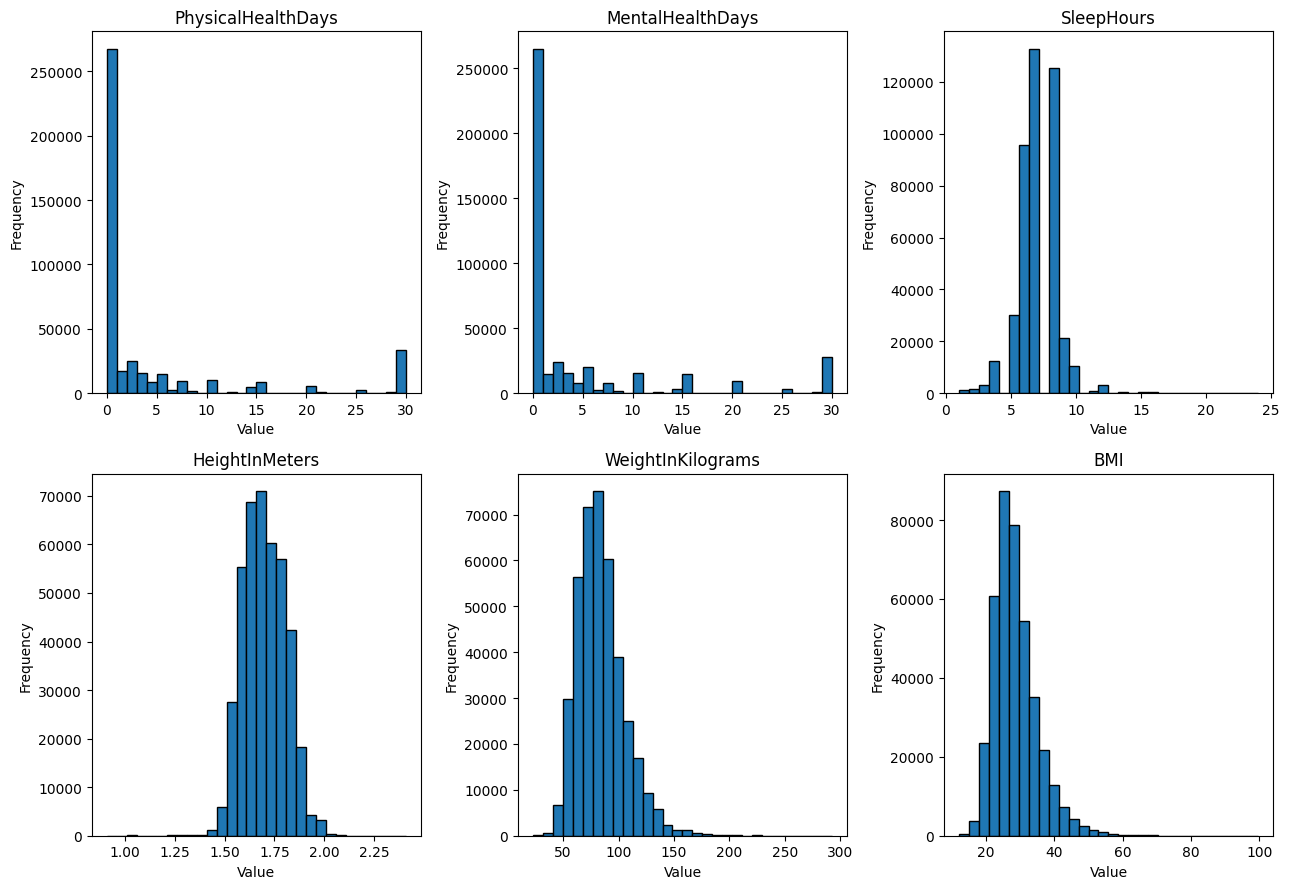

In [11]:
# Examining distribution of numerical features in Histograms:

# Define numerical columns for histograms
numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']

# Set up the figure and axes & flatten
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 9))
axes = axes.flatten()

# Plot histograms for each numerical feature
for i, col in enumerate(numerical_columns):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Plot the data
plt.tight_layout()
plt.show()

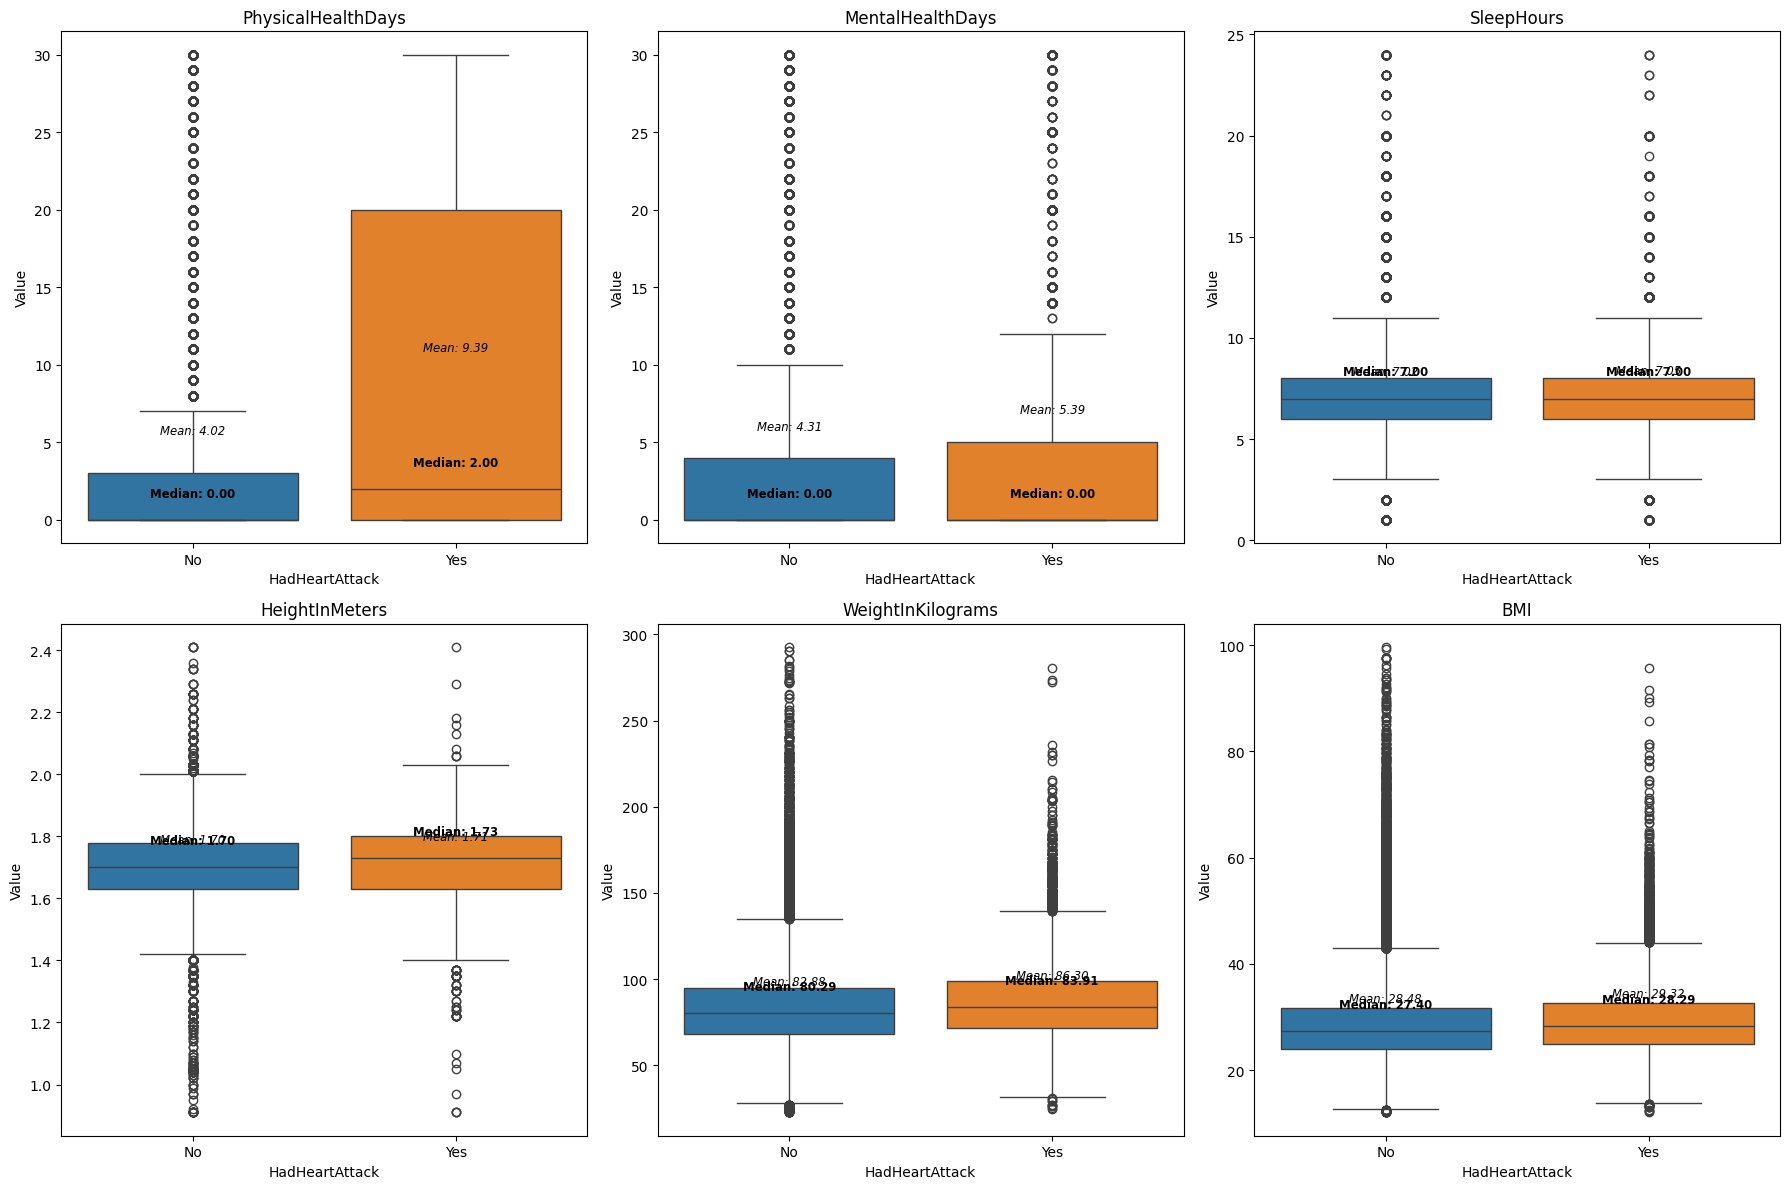

In [12]:
# Comparing Box Plots for Numerical Features, split by our Target Variable: Had Heart Attack vs. had NOT had a Heart AttackHeart

# Define numerical columns for box plots
numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']

# Define the number of rows and columns for subplots
n_cols = 3
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Set up the figure and axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define colors for the box plots
colors = ["#1f77b4", "#ff7f0e"]  

# Plot boxplots for each numerical feature by 'HadHeartAttack'
for i, col in enumerate(numerical_columns):
    sns.boxplot(x='HadHeartAttack', y=col, data=df, ax=axes[i], palette=colors)
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('HadHeartAttack', fontsize=10)
    axes[i].set_ylabel('Value', fontsize=10)
    
    # Add mean and median values
    medians = df.groupby('HadHeartAttack')[col].median()
    means = df.groupby('HadHeartAttack')[col].mean()
    
    for tick, label in zip(axes[i].get_xticks(), axes[i].get_xticklabels()):
        axes[i].text(tick, medians[tick] + 0.05 * (df[col].max() - df[col].min()), f'Median: {medians[tick]:.2f}', 
                     horizontalalignment='center', size='small', color='black', weight='semibold')
        axes[i].text(tick, means[tick] + 0.05 * (df[col].max() - df[col].min()), f'Mean: {means[tick]:.2f}', 
                     horizontalalignment='center', size='small', color='black', style='italic')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and plot the data
plt.tight_layout()
plt.show()

### Highlight from examining Box Plots:

- Those who had a Heart Attack (mean = 9.4) took more than 2x more Physical Health Days vs. those who did Not have a Heart Attack (mean = 4.0)
- Those who had a Heart Attack (mean = 5.4) also took slightly more Mental Health Days vs. those who did Not have a Heart Attack (mean = 4.3)
- No significant difference between the positive and negative target class explicit for other features

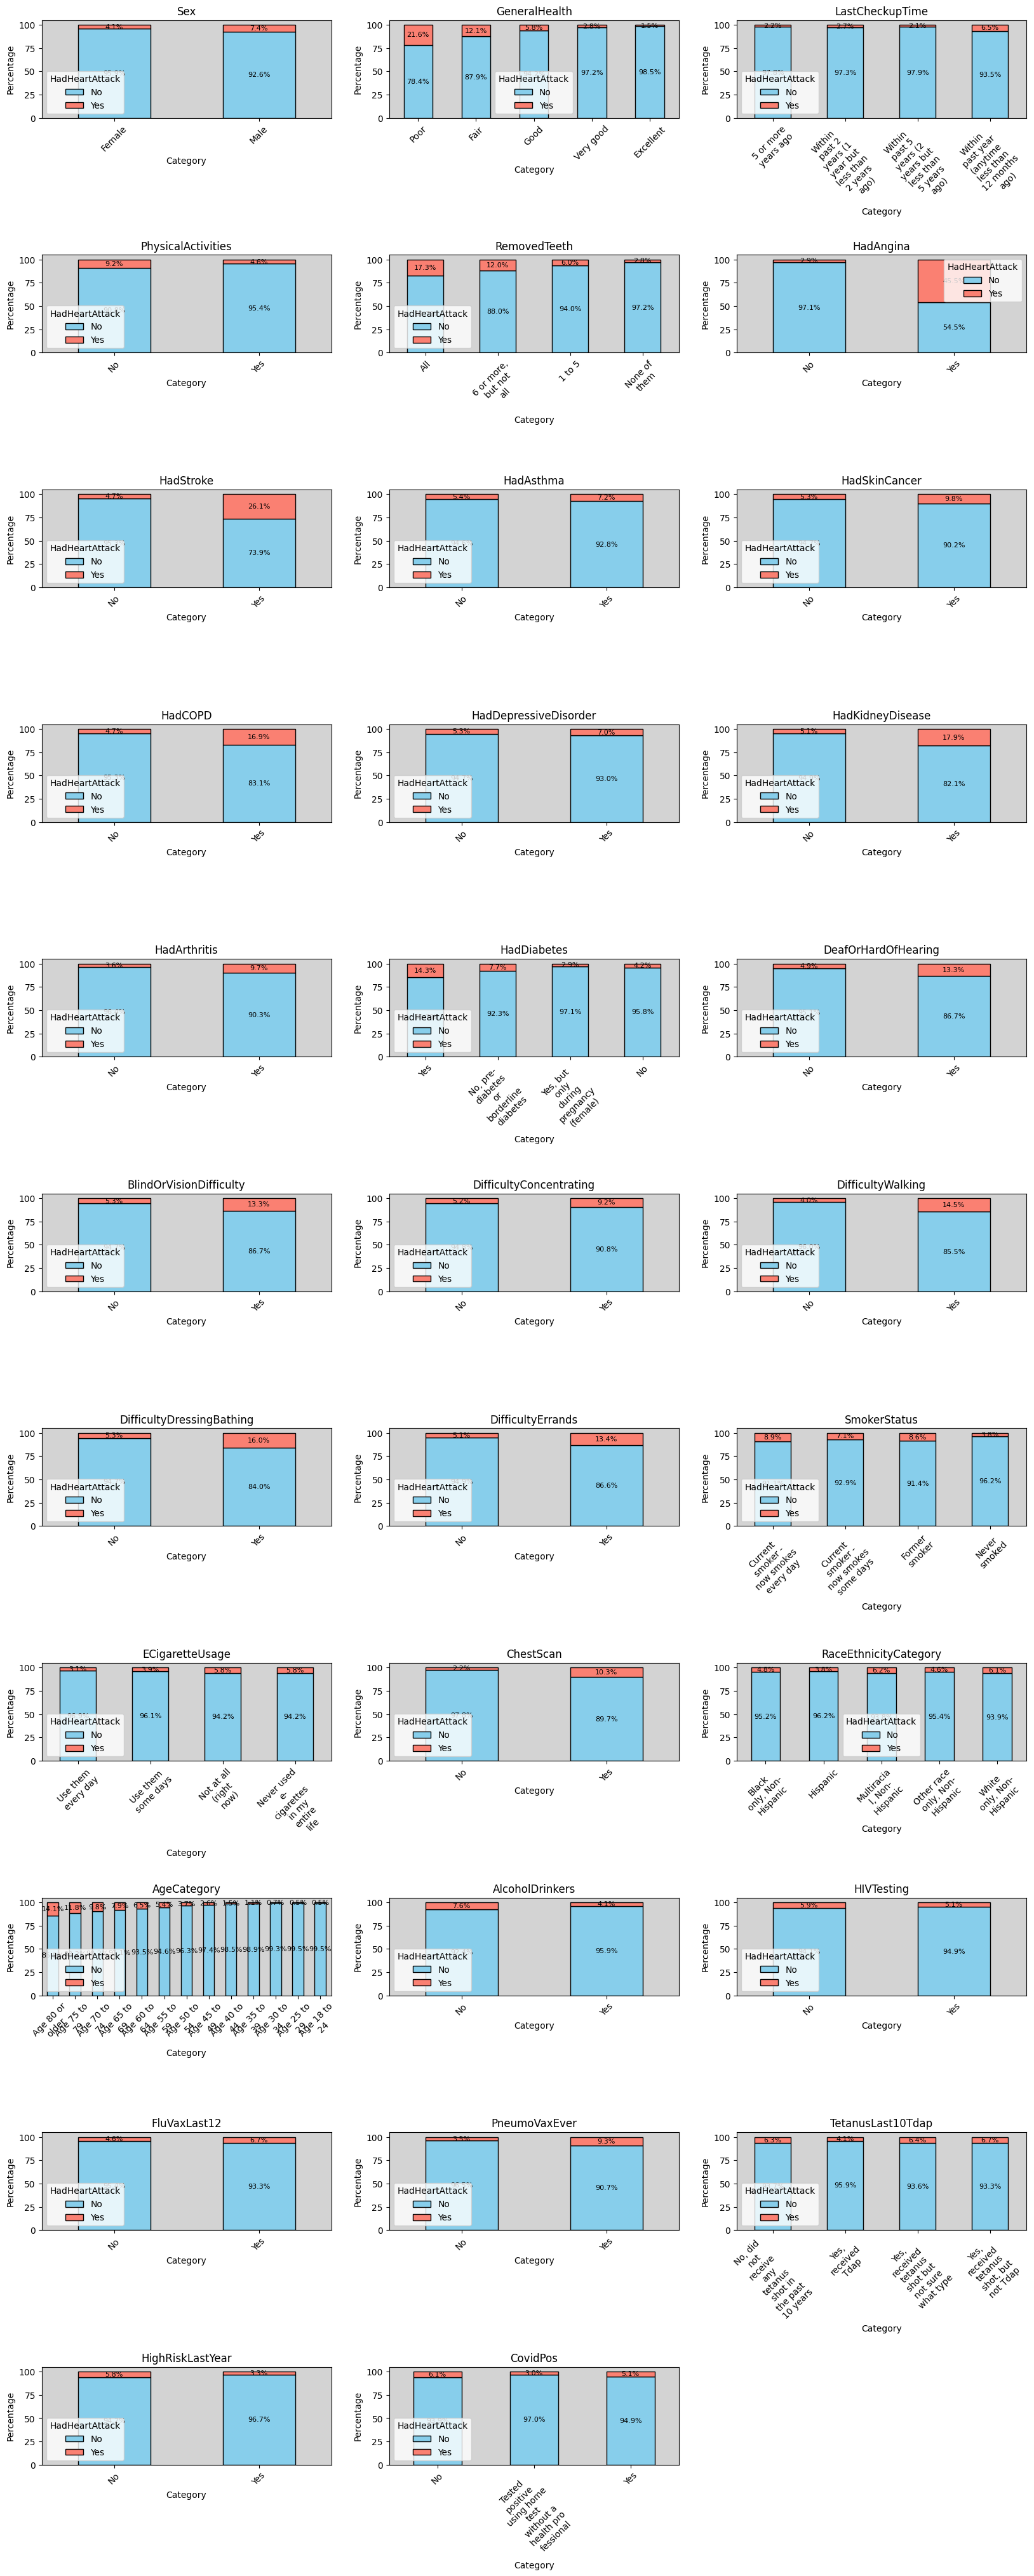

In [13]:
# Bar charts to get familiar with caregorical features, color-coded by target variable

# Define categorical columns for bar plots
categorical_columns = ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 
                       'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 
                       'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 
                       'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 
                       'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 
                       'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 
                       'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 
                       'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 
                       'CovidPos']

# Define ordinal features and their orders
ordinal_features = ['GeneralHealth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory', 'HadDiabetes', 'RemovedTeeth']

ordinal_categories = {
    'GeneralHealth': ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'],
    'SmokerStatus': ['Current smoker - now smokes every day', 'Current smoker - now smokes some days', 'Former smoker', 'Never smoked'],
    'ECigaretteUsage': ['Use them every day', 'Use them some days', 'Not at all (right now)', 'Never used e-cigarettes in my entire life'],
    'AgeCategory': ['Age 80 or older', 'Age 75 to 79', 'Age 70 to 74', 'Age 65 to 69', 'Age 60 to 64', 
                    'Age 55 to 59', 'Age 50 to 54', 'Age 45 to 49', 'Age 40 to 44', 'Age 35 to 39', 
                    'Age 30 to 34', 'Age 25 to 29', 'Age 18 to 24'],
    'HadDiabetes': ['Yes', 'No, pre-diabetes or borderline diabetes', 'Yes, but only during pregnancy (female)', 'No'],
    'RemovedTeeth': ['All', '6 or more, but not all', '1 to 5', 'None of them']
}

# Define the number of rows and columns for subplots
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  

# Set up the figure and axes & flatten for easy iteration
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 50))
axes = axes.flatten()

# Define a function to wrap text
def wrap_labels(ax, width):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45, ha='center', fontsize=10)

# Plot 100% stacked bar plots for each categorical feature
for i, col in enumerate(categorical_columns):
    # Create a crosstab to get counts for each category divided by HadHeartAttack
    crosstab = pd.crosstab(df[col], df['HadHeartAttack'])
    order = ordinal_categories[col] if col in ordinal_features else None
    crosstab = crosstab.reindex(order) if order else crosstab
    
    # Calculate the percentage for each category
    crosstab_perc = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar plot
    ax = crosstab_perc.plot(kind='bar', stacked=True, ax=axes[i], edgecolor='black', color=['skyblue', 'salmon'])
    
    # Annotate the bars with the percentage
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=8, color='black')

    ax.set_title(col, fontsize=12)
    ax.set_xlabel('Category', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.tick_params(axis='y', labelsize=10)
    wrap_labels(ax, 10)
    ax.set_facecolor('lightgrey') 

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap and add horizontal space
plt.subplots_adjust(wspace=0.2, hspace=1.4)
plt.show()


### Key Findings from Examining Categorical Features by Target Variable:
- Angina: 46% of those who had a heart attack also had angina, compared to only 3% of those who didn't have a heart attack. 
- COPD (chronic bronchitis): 16.9% of heart attack victims had COPD, versus 4.7% of those without heart attacks.
- Stroke: 26.1% of individuals who had a heart attack also had a stroke, compared to 4.7% of those without a heart attack.
- Kidney Disease: 17.9% of heart attack cases had kidney disease, versus 5.1% of non-heart attack cases.
- Diabetes: 14.3% of those who had a heart attack also had diabetes, compared to 4.2% of those who didn't.
- Gender Disparity: 7.4% of males had a heart attack compared to 4.1% of females.
- General Health: The likelihood of heart attacks increases as general health conditions worsen.
- Age: The percentage of heart attack cases increases with age, surpassing 10% starting at age 70.

## 2. Data Cleanup & Preparation

In [14]:
# Check for NaN values
nan_summary = df.isna().sum()
nan_summary = nan_summary[nan_summary > 0]  # Filter to show only columns with NaN values

# Display the summary of NaN values
print("Summary of NaN values in each column:")
print(nan_summary)


Summary of NaN values in each column:
GeneralHealth                 1193
PhysicalHealthDays           10922
MentalHealthDays              9062
LastCheckupTime               8301
PhysicalActivities            1088
SleepHours                    5448
RemovedTeeth                 11355
HadHeartAttack                3060
HadAngina                     4400
HadStroke                     1552
HadAsthma                     1768
HadSkinCancer                 3138
HadCOPD                       2214
HadDepressiveDisorder         2807
HadKidneyDisease              1921
HadArthritis                  2628
HadDiabetes                   1082
DeafOrHardOfHearing          20502
BlindOrVisionDifficulty      21419
DifficultyConcentrating      24095
DifficultyWalking            23867
DifficultyDressingBathing    23770
DifficultyErrands            25511
SmokerStatus                 35316
ECigaretteUsage              35514
ChestScan                    55900
RaceEthnicityCategory        14048
AgeCategory      

In [15]:
# # List of features to remove: State as it's not relevant, and BMI as it is highly correlated with weight, and most people will know their weight before they know their BMI. Remove WeightInKilograms and retain the WeightCategory
features_to_remove = ['State', 'BMI', 'LastCheckupTime', 'TetanusLast10Tdap', 'HIVTesting', 'FluVaxLast12']

# Remove the specified features
df = df.drop(columns=features_to_remove)

# Display the remaining columns
print("Remaining columns in df:")
print(df.columns)


Remaining columns in df:
Index(['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadHeartAttack',
       'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'AlcoholDrinkers',
       'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')


In [16]:
# Check for NaN values
nan_summary = df.isna().sum()
nan_summary = nan_summary[nan_summary > 0]  # Filter to show only columns with NaN values

# Calculate percentage of NaN values
nan_percentage = (nan_summary / len(df)) * 100

# Calculate the total number of rows where HadHeartAttack is Yes
total_heart_attack_yes = len(df[df['HadHeartAttack'] == 'Yes'])

# Calculate the percentage of NaN values in HadHeartAttack = Yes rows
nan_heart_attack_yes = df[df['HadHeartAttack'] == 'Yes'].isna().sum()
nan_heart_attack_yes_percentage = (nan_heart_attack_yes / total_heart_attack_yes) * 100

# Combine the information into a DataFrame for better display
nan_info = pd.DataFrame({
    'NaN Count': nan_summary,
    '% of Total': nan_percentage,
    '% of HadHeartAttack=Yes': nan_heart_attack_yes_percentage
})

# Display the summary of NaN values
print("Summary of NaN values in each column:")
print(nan_info)


Summary of NaN values in each column:
                           NaN Count  % of Total  % of HadHeartAttack=Yes
AgeCategory                   9069.0    2.038092                 1.433806
AlcoholDrinkers              46428.0   10.433845                10.064521
BlindOrVisionDifficulty      21419.0    4.813529                 4.444798
ChestScan                    55900.0   12.562504                12.756890
CovidPos                     50618.0   11.375471                10.912856
DeafOrHardOfHearing          20502.0    4.607450                 4.341246
DifficultyConcentrating      24095.0    5.414911                 5.117891
DifficultyDressingBathing    23770.0    5.341873                 4.779353
DifficultyErrands            25511.0    5.733131                 5.221443
DifficultyWalking            23867.0    5.363672                 4.978493
ECigaretteUsage              35514.0    7.981123                 7.842122
GeneralHealth                 1193.0    0.268105                 0.450056


### Filling and Removing NaN Values:
- Filling NaN values for Target variable HadHeartAttack = Yes with Mode for Categorical Features and Median for Numerical features
- Removing rows with NaN values, where Target variable HadHeartAttack = No
- Filling NaN values for positive target variable rows retains the under-represented data class
- Removing NaN rows with negative target variable removes ~34% of the overall data, not affecting the positive class
- Removing NaNs keeps the negative target variable rows accuracy (with no substitutions) & still leaves a large dataset of ~293k
- Having less negative target variable rows improves data imbalance, increasing the share of positive cases from 5.7% to 8.6%

In [17]:
# Identify categorical and numerical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include=['number']).columns

# Create a copy of the dataframe to avoid modifying the original dataframe
df_cleaned = df.copy()

# Check for NaN values
nan_summary = df_cleaned.isna().sum()
# Filter to show only columns with NaN values
nan_summary = nan_summary[nan_summary > 0]  

# Store initial count of rows where HadHeartAttack is Yes
initial_heart_attack_yes_count = len(df_cleaned[df_cleaned['HadHeartAttack'] == 'Yes'])

# Fill NaN values for rows where HadHeartAttack is Yes
for col in nan_summary.index:
    if col in categorical_features:
        mode_value = df_cleaned[col].mode()[0]
        df_cleaned.loc[(df_cleaned['HadHeartAttack'] == 'Yes') & (df_cleaned[col].isna()), col] = mode_value
    elif col in numerical_features:
        median_value = df_cleaned[col].median()
        df_cleaned.loc[(df_cleaned['HadHeartAttack'] == 'Yes') & (df_cleaned[col].isna()), col] = median_value

# Define columns to fill with mode or median where HadHeartAttack is No
columns_to_fill = ['HeightInMeters']

# Fill NaN values for rows where HadHeartAttack is No
for col in columns_to_fill:
    if col in categorical_features:
        mode_value = df_cleaned[col].mode()[0]
        df_cleaned.loc[(df_cleaned['HadHeartAttack'] == 'No') & (df_cleaned[col].isna()), col] = mode_value
    elif col in numerical_features:
        median_value = df_cleaned[col].median()
        df_cleaned.loc[(df_cleaned['HadHeartAttack'] == 'No') & (df_cleaned[col].isna()), col] = median_value

# Count the number of rows with NaN values before removal
nan_rows_count_before = df_cleaned.isna().sum(axis=1).gt(0).sum()

# Drop rows with NaN values where HadHeartAttack is No (except the specified columns)
df_cleaned_no = df_cleaned[df_cleaned['HadHeartAttack'] == 'No'].dropna(subset=nan_summary.index.difference(columns_to_fill), how='any')
df_cleaned_yes = df_cleaned[df_cleaned['HadHeartAttack'] == 'Yes']

# Combine the cleaned dataframes
df_cleaned = pd.concat([df_cleaned_yes, df_cleaned_no])

# Count the number of rows with NaN values after removal
nan_rows_count_after = df_cleaned.isna().sum(axis=1).gt(0).sum()

# Confirm the count of rows where HadHeartAttack is Yes
final_heart_attack_yes_count = len(df_cleaned[df_cleaned['HadHeartAttack'] == 'Yes'])

# Summary of NaN handling
print(f"\nSummary of NaN Handling:")
print(f"Total rows with NaNs removed: {nan_rows_count_before - nan_rows_count_after}")
print(f"Total 'HadHeartAttack = Yes' before handling NaNs: {initial_heart_attack_yes_count}")
print(f"Total 'HadHeartAttack = Yes' after handling NaNs: {final_heart_attack_yes_count}")



Summary of NaN Handling:
Total rows with NaNs removed: 152289
Total 'HadHeartAttack = Yes' before handling NaNs: 25108
Total 'HadHeartAttack = Yes' after handling NaNs: 25108


In [18]:
# Check for remaining NaNs
print(df_cleaned.isna().sum())

Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
AlcoholDrinkers              0
PneumoVaxEver                0
HighRisk

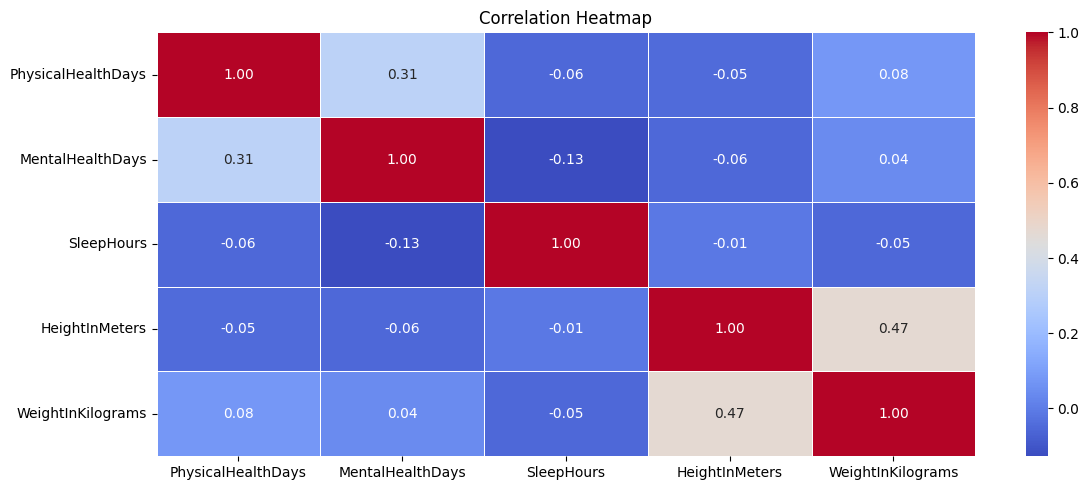

In [19]:
# Select only numerical columns for correlation matrix
numerical_df = df_cleaned.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)

# Display the heatmap
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [20]:
df_cleaned.sample(5)

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,...,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,AlcoholDrinkers,PneumoVaxEver,HighRiskLastYear,CovidPos
61786,Female,Excellent,0.0,0.0,Yes,7.0,None of them,No,No,No,...,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 70 to 74,1.68,63.50,No,Yes,No,No
28253,Female,Good,2.0,2.0,Yes,7.0,All,No,No,No,...,Not at all (right now),No,"White only, Non-Hispanic",Age 55 to 59,1.63,63.50,Yes,Yes,No,No
389287,Male,Very good,0.0,0.0,Yes,7.0,None of them,No,No,No,...,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 70 to 74,1.75,77.11,No,Yes,No,No
313203,Female,Excellent,0.0,15.0,Yes,8.0,None of them,No,No,No,...,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 30 to 34,1.60,52.16,Yes,No,No,No
415910,Male,Good,2.0,5.0,Yes,7.0,None of them,No,No,No,...,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 65 to 69,1.75,83.91,Yes,No,No,No


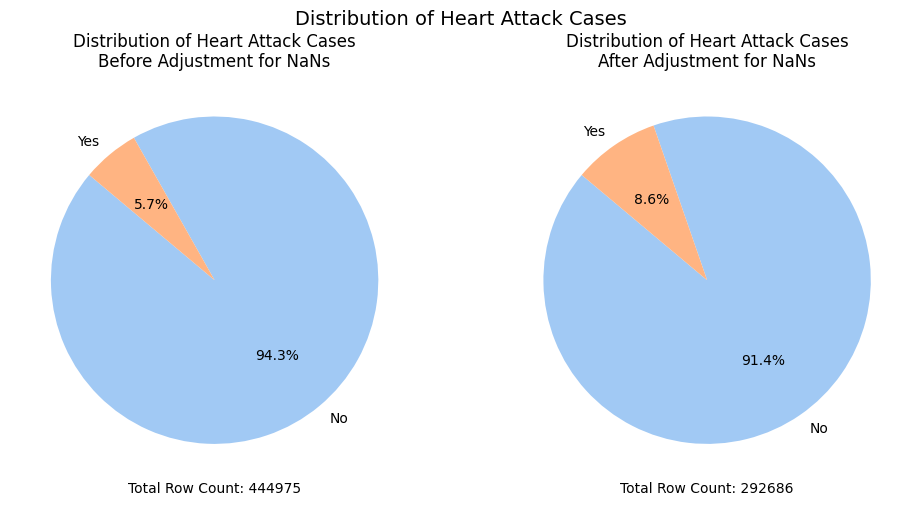

In [21]:
# Count the occurrences of each category in the 'HadHeartAttack' column for both df and df_cleaned
heart_attack_counts_before = df['HadHeartAttack'].value_counts()
heart_attack_counts_after = df_cleaned['HadHeartAttack'].value_counts()

# Total row counts
total_rows_before = len(df)
total_rows_after = len(df_cleaned)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the pie chart for df (before adjustment for NaNs)
axes[0].pie(
    heart_attack_counts_before, 
    labels=heart_attack_counts_before.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel'), 
    textprops={'fontsize': 10}  
)
axes[0].set_title('Distribution of Heart Attack Cases\nBefore Adjustment for NaNs', fontsize=12)
axes[0].text(0, -1.3, f'Total Row Count: {total_rows_before}', ha='center', fontsize=10)

# Plot the pie chart for df_cleaned (after adjustment for NaNs)
axes[1].pie(
    heart_attack_counts_after, 
    labels=heart_attack_counts_after.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel'), 
    textprops={'fontsize': 10}  
)
axes[1].set_title('Distribution of Heart Attack Cases\nAfter Adjustment for NaNs', fontsize=12)
axes[1].text(0, -1.3, f'Total Row Count: {total_rows_after}', ha='center', fontsize=10)

# Set the main title for the figure
fig.suptitle('Distribution of Heart Attack Cases', fontsize=14)

# Show the plots
plt.tight_layout()
plt.show()


## 3. Data Preprocessing: Scaling and Encoding Data

In [22]:
# Convert 'HadHeartAttack' column to binary
df_cleaned['HadHeartAttack'] = df_cleaned['HadHeartAttack'].map({'Yes': 1, 'No': 0})

# Separate the target variable and features
y = df_cleaned['HadHeartAttack']
X = df_cleaned.drop(columns=['HadHeartAttack'])

# Define numerical features
numerical_features = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms']

# Define ordinal features and their orders
ordinal_features = ['GeneralHealth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory', 'HadDiabetes', 'RemovedTeeth']

ordinal_categories = [
    ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'],  # GeneralHealth
    ['Current smoker - now smokes every day', 'Current smoker - now smokes some days', 'Former smoker', 'Never smoked'],  # SmokerStatus
    ['Use them every day', 'Use them some days', 'Not at all (right now)', 'Never used e-cigarettes in my entire life'],  # ECigaretteUsage
    ['Age 80 or older', 'Age 75 to 79', 'Age 70 to 74', 'Age 65 to 69', 'Age 60 to 64', 'Age 55 to 59', 'Age 50 to 54', 
     'Age 45 to 49', 'Age 40 to 44', 'Age 35 to 39', 'Age 30 to 34', 'Age 25 to 29', 'Age 18 to 24'],  # AgeCategory
    ['Yes', 'No, pre-diabetes or borderline diabetes', 'Yes, but only during pregnancy (female)', 'No'],  # HadDiabetes
    ['All', '6 or more, but not all', '1 to 5', 'None of them']  # RemovedTeeth
]

# Define binary nominal features
binary_nominal_features = [
    'PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 
    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 
    'ChestScan', 'AlcoholDrinkers', 'PneumoVaxEver', 'HighRiskLastYear'
]

# Define remaining nominal features
remaining_nominal_features = [feature for feature in X.columns if feature not in numerical_features + ordinal_features + binary_nominal_features]

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
        ('bin', OneHotEncoder(drop='if_binary'), binary_nominal_features),
        ('nom', OneHotEncoder(handle_unknown='ignore'), remaining_nominal_features)
    ])

# Apply the preprocessing pipeline to your real dataset
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Example: Checking the transformed shape
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Training set shape: (234148, 40)
Test set shape: (58538, 40)


## 4. Data Modeling & Evaluation

### Key Metrics 

- Primary Metric: Recall – Ensure that you identify as many actual positive cases as possible, minimizing the number of false negatives (FN)
- Secondary Metric: F1 Score – Balance precision and recall to have a more balanced evaluation of model performance.

### Standardizing Model Output & Evaluation

In [23]:
# Function to evaluate model performance and return results
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=None):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'Training Time: {training_time:.4f} seconds')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('\n')
    
    return {
        'Model': model_name if model_name else model.__class__.__name__,
        'Training Time': round(training_time, 2),
        'Accuracy': round(accuracy, 2),
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1 Score': round(f1, 2),
        'ROC AUC': round(roc_auc, 2),
        'Confusion Matrix': conf_matrix.tolist()  # Convert array to list for better display
    }


# List to store results
results_list = []

### Dummy Classifer

In [24]:
# Create a dummy classifier with stratified strategy to compensate for the class imbalance
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_results = evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)
results_list.append(dummy_results)

Training Time: 0.0087 seconds
Accuracy: 0.8459
Precision: 0.0909
Recall: 0.0919
F1 Score: 0.0914
ROC AUC Score: 0.5036
Confusion Matrix:
[[49061  4539]
 [ 4484   454]]




### Logistic Regression

In [25]:
# Train a logistic regression model with balanced class weights
logreg = LogisticRegression(max_iter=10000, class_weight='balanced')  # class_weight='balanced' helps with imbalance
logreg.fit(X_train, y_train)
y_logreg_pred = logreg.predict(X_test)
logreg_results = evaluate_model(logreg, X_train, y_train, X_test, y_test)
results_list.append(logreg_results)

Training Time: 2.5514 seconds
Accuracy: 0.8307
Precision: 0.2994
Recall: 0.7513
F1 Score: 0.4281
ROC AUC Score: 0.7947
Confusion Matrix:
[[44917  8683]
 [ 1228  3710]]




### K-Nearest Neighbors (KNN)

In [26]:
# Train and evaluate K-Nearest Neighbors (KNN)
print("K-Nearest Neighbors (KNN):")
knn = KNeighborsClassifier()
knn_results = evaluate_model(knn, X_train, y_train, X_test, y_test)
results_list.append(knn_results)

K-Nearest Neighbors (KNN):
Training Time: 0.0225 seconds
Accuracy: 0.9173
Precision: 0.5358
Recall: 0.1499
F1 Score: 0.2342
ROC AUC Score: 0.5689
Confusion Matrix:
[[52959   641]
 [ 4198   740]]




### Decision Tree

In [27]:
# Train and evaluate Decision Tree
print("Decision Tree:")
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_results = evaluate_model(dt, X_train, y_train, X_test, y_test)
results_list.append(dt_results)

Decision Tree:
Training Time: 2.0803 seconds
Accuracy: 0.8904
Precision: 0.3510
Recall: 0.3520
F1 Score: 0.3515
ROC AUC Score: 0.6460
Confusion Matrix:
[[50386  3214]
 [ 3200  1738]]




### Random Forest

In [28]:
# Train and evaluate Random Forest
print("Random Forest:")
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_results = evaluate_model(rf, X_train, y_train, X_test, y_test)
results_list.append(rf_results)

Random Forest:
Training Time: 24.3281 seconds
Accuracy: 0.9273
Precision: 0.6592
Recall: 0.2864
F1 Score: 0.3993
ROC AUC Score: 0.6364
Confusion Matrix:
[[52869   731]
 [ 3524  1414]]




### XGBoost

In [29]:
# Calculate the scale_pos_weight & Train and Evaluate XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
print("XGBoost:")
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_results = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)
results_list.append(xgb_results)


XGBoost:
Training Time: 0.8158 seconds
Accuracy: 0.8389
Precision: 0.3132
Recall: 0.7623
F1 Score: 0.4440
ROC AUC Score: 0.8041
Confusion Matrix:
[[45346  8254]
 [ 1174  3764]]




### Improving XGBoost

- XGBoost performed the best on the Recall measure above with a score of 0.76.
- Next we try the SMOTE and Undersampling techniques in hopes to address the class imbalance issue and imrpve our Recall score.
- SMOTE adds more samples from the Positive target (underrepresented class - Having Heart Disease)
- Undersampling removes samples from the Negative target (overrepresented class - NOT having heart disease)

In [30]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'Original dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_train_resampled)}')

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Evaluate the model
evaluate_model(xgb_model, X_train_resampled, y_train_resampled, X_test, y_test)


Original dataset shape Counter({0: 213978, 1: 20170})
Resampled dataset shape Counter({0: 213978, 1: 213978})
Training Time: 2.0471 seconds
Accuracy: 0.9303
Precision: 0.6394
Recall: 0.3971
F1 Score: 0.4899
ROC AUC Score: 0.6882
Confusion Matrix:
[[52494  1106]
 [ 2977  1961]]




{'Model': 'XGBClassifier',
 'Training Time': 2.05,
 'Accuracy': 0.93,
 'Precision': 0.64,
 'Recall': 0.4,
 'F1 Score': 0.49,
 'ROC AUC': 0.69,
 'Confusion Matrix': [[52494, 1106], [2977, 1961]]}

In [31]:
# Apply undersampling to the majority class
undersample = RandomUnderSampler(sampling_strategy= 0.3, random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

print(f'Original dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_train_resampled)}')

# Initialize and train XGBoost with class weights
xgb_model = xgb.XGBClassifier(scale_pos_weight=(len(y_train_resampled) / sum(y_train_resampled)), use_label_encoder=False, eval_metric='logloss', random_state=42)

# Evaluate the model
evaluate_model(xgb_model, X_train_resampled, y_train_resampled, X_test, y_test)

Original dataset shape Counter({0: 213978, 1: 20170})
Resampled dataset shape Counter({0: 67233, 1: 20170})
Training Time: 0.6496 seconds
Accuracy: 0.8011
Precision: 0.2716
Recall: 0.8072
F1 Score: 0.4064
ROC AUC Score: 0.8039
Confusion Matrix:
[[42910 10690]
 [  952  3986]]




{'Model': 'XGBClassifier',
 'Training Time': 0.65,
 'Accuracy': 0.8,
 'Precision': 0.27,
 'Recall': 0.81,
 'F1 Score': 0.41,
 'ROC AUC': 0.8,
 'Confusion Matrix': [[42910, 10690], [952, 3986]]}

### XGBoost with Undersampling
- XGBoost with Undersampling performs better with 80% Recall score (up from 76% from original XGBoost model) 
- Undersampling: We chose to reduce the Negative Target variable sample to increase the Positive Target Sample to 30% (up from original 8.6%)
- 30% still maintans the Positive class as a minority and retains a decent F1 score of 41%
- Below we apply GridSearch CV to our new improved XGBoost Model with Undersampling
- XGBoost with Undersampling & Best Parameters results in our best model yet with Recall = 91% and a slightly lower F1 score of 30%

In [32]:
# Define new param grid with reasonable ranges
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [(len(y_train_resampled) / sum(y_train_resampled))]
}

# Define custom scoring function for recall
recall_scorer = make_scorer(recall_score)

# Initialize XGBoost classifier without use_label_encoder
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Set up GridSearchCV with custom scoring
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=0, n_jobs=-1, scoring=recall_scorer)

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Evaluate the best model using the pre-defined evaluate_model function
xgb_best_params_resampled_results = evaluate_model(best_xgb, X_train_resampled, y_train_resampled, X_test, y_test, model_name='XGB Best Params Resampled')

# Add results to the list
results_list.append(xgb_best_params_resampled_results)

# Print the best parameters
print("Best hyperparameters found: ", grid_search.best_params_)


Training Time: 0.3889 seconds
Accuracy: 0.6424
Precision: 0.1795
Recall: 0.9066
F1 Score: 0.2996
ROC AUC Score: 0.7624
Confusion Matrix:
[[33129 20471]
 [  461  4477]]


Best hyperparameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 4.333316807139316, 'subsample': 0.9}


## 5. Evaluating Model Results

### Examining Most Important Features for Prediction

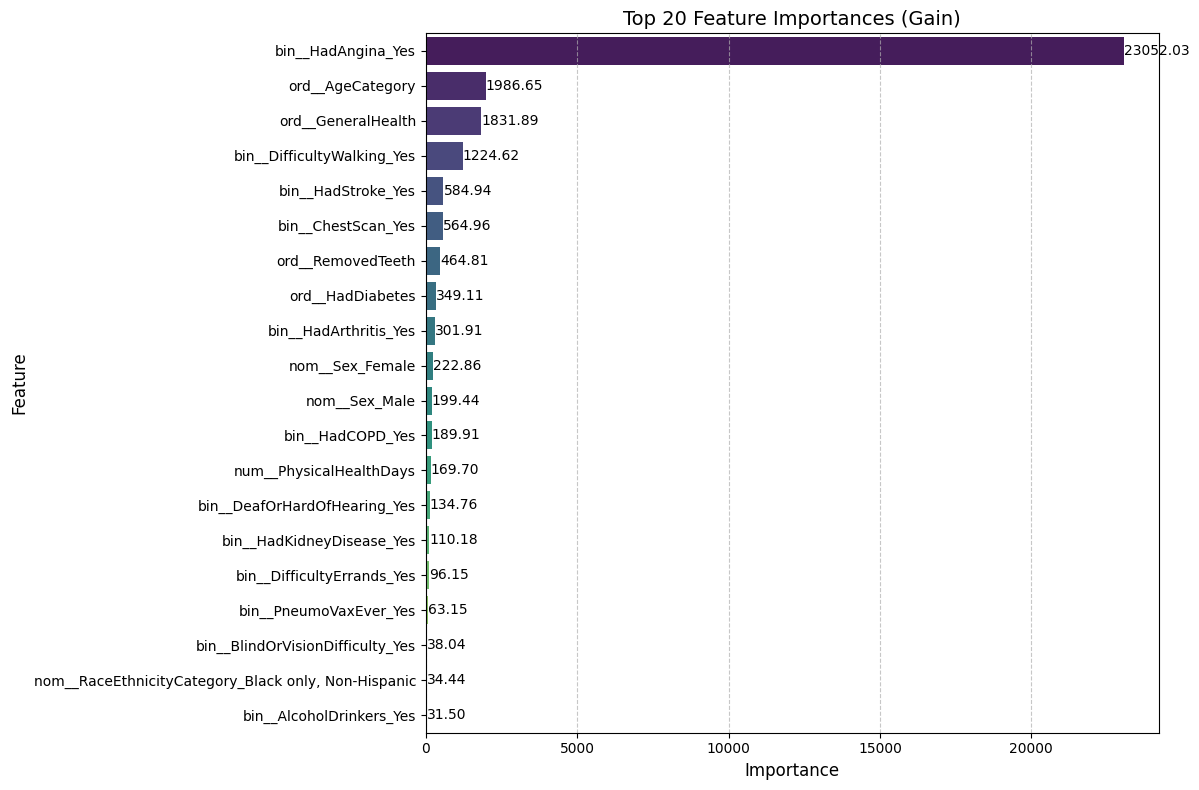

In [33]:
# Get feature importances
feature_importances = best_xgb.get_booster().get_score(importance_type='gain')

# Get the original feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame with feature names
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in feature_importances.keys()],
    'Importance': feature_importances.values()
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top 20 features
top_20_importance_df = importance_df.head(20)

# Plot top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_importance_df, palette='viridis')

# Adding title and labels
plt.title('Top 20 Feature Importances (Gain)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Rotate the y-axis labels for better readability
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add values to the bars
for index, value in enumerate(top_20_importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

# Adjust layout 
plt.tight_layout()
plt.show()


### Summary: All Model Results

In [34]:
# Convert results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Sort the DataFrame by the 'Recall' column in descending order
results_df_sorted = results_df.sort_values(by='Recall', ascending=False)

# Format the DataFrame to show two decimal points
pd.options.display.float_format = '{:.2f}'.format

# Display the sorted DataFrame using tabulate
print(tabulate(results_df_sorted, headers='keys', tablefmt='psql'))



+----+---------------------------+-----------------+------------+-------------+----------+------------+-----------+-------------------------------+
|    | Model                     |   Training Time |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC | Confusion Matrix              |
|----+---------------------------+-----------------+------------+-------------+----------+------------+-----------+-------------------------------|
|  6 | XGB Best Params Resampled |            0.39 |       0.64 |        0.18 |     0.91 |       0.3  |      0.76 | [[33129, 20471], [461, 4477]] |
|  5 | XGBClassifier             |            0.82 |       0.84 |        0.31 |     0.76 |       0.44 |      0.8  | [[45346, 8254], [1174, 3764]] |
|  1 | LogisticRegression        |            2.55 |       0.83 |        0.3  |     0.75 |       0.43 |      0.79 | [[44917, 8683], [1228, 3710]] |
|  3 | DecisionTreeClassifier    |            2.08 |       0.89 |        0.35 |     0.35 |       0.35 |      0.6

### Visualizing Model Results
- Comparing models, descending by our most important Key Metric - Recall
- Comparing model training time
- Comparing model F1 Score
- Comparing model Accuracy

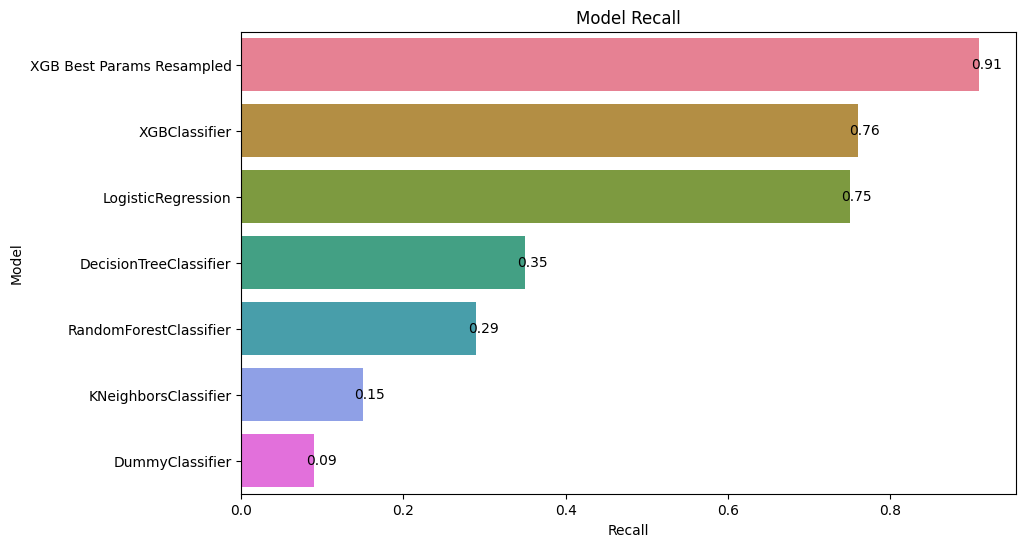

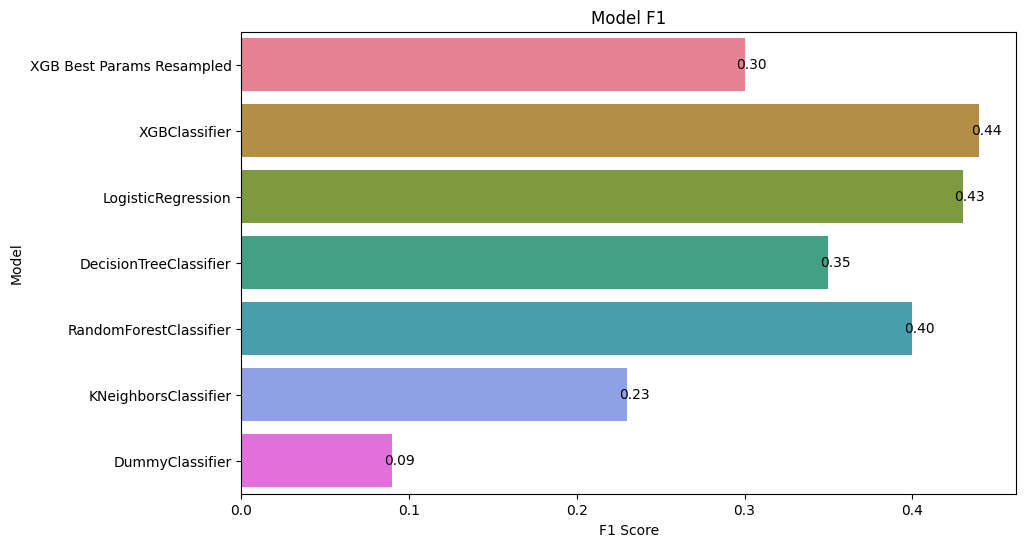

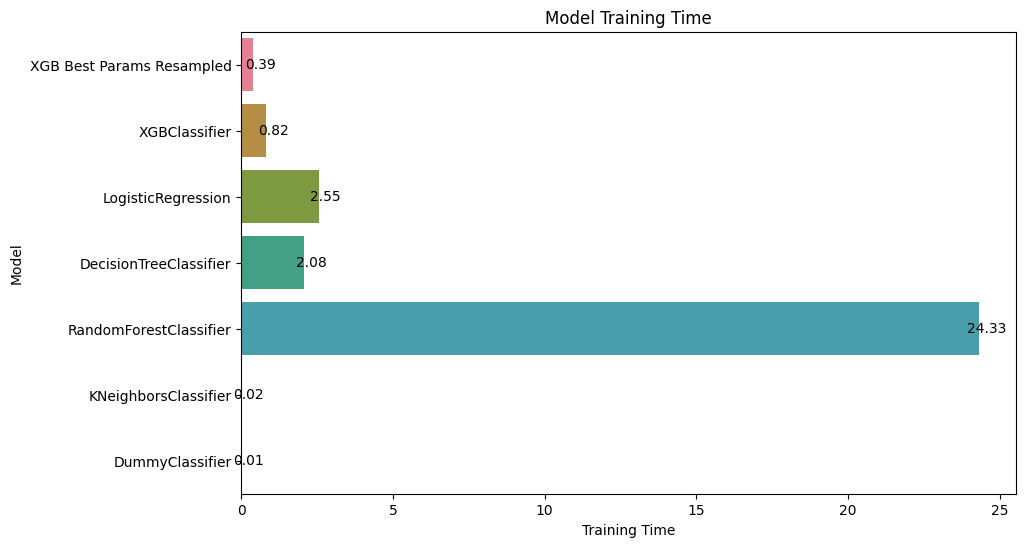

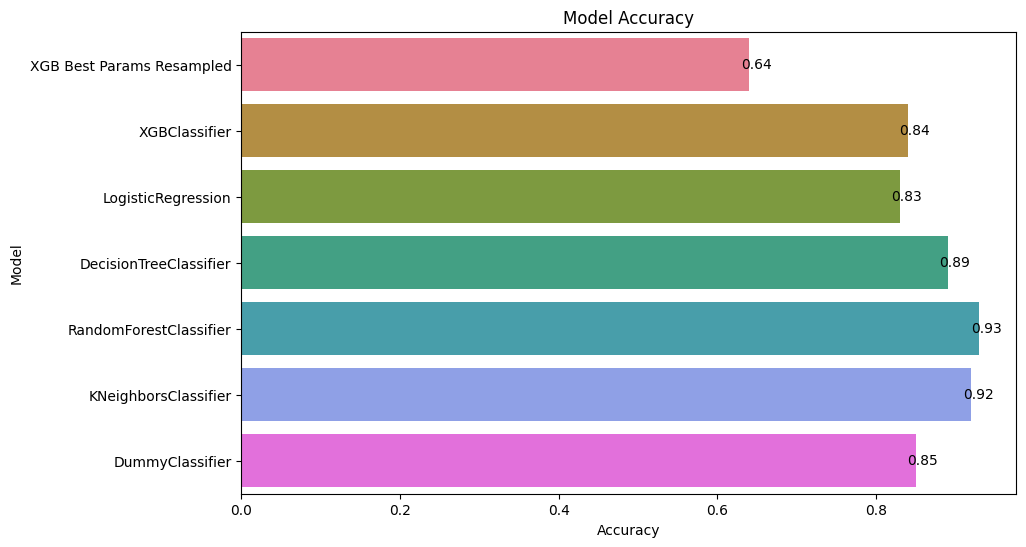

In [36]:
# Select the relevant columns
metrics_df = results_df_sorted[['Model', 'Recall', 'F1 Score', 'Training Time', 'Accuracy']]

# Define a color palette
palette = sns.color_palette('husl', len(metrics_df))

# Create a dictionary to map models to colors
model_colors = {model: color for model, color in zip(metrics_df['Model'], palette)}

def add_value_labels(ax):
    """Add labels to the bars in the bar plot."""
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.2f'),
                    (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha = 'center', va = 'center',
                    xytext = (5, 0), textcoords = 'offset points')

# Plot Recall
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Recall', y='Model', data=metrics_df, palette=model_colors)
add_value_labels(ax)
plt.title('Model Recall')
plt.show()

# Plot F1
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='F1 Score', y='Model', data=metrics_df, palette=model_colors)
add_value_labels(ax)
plt.title('Model F1')
plt.show()

# Plot Training Time
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Training Time', y='Model', data=metrics_df, palette=model_colors)
add_value_labels(ax)
plt.title('Model Training Time')
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Accuracy', y='Model', data=metrics_df, palette=model_colors)
add_value_labels(ax)
plt.title('Model Accuracy')
plt.show()
